In [24]:
# Cell 1: Setup and imports
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'  # You can change to 'jax' or 'torch' if preferred

import numpy as np
import keras
import sentencepiece as spm

print(f"Keras version: {keras.__version__}")
print(f"Keras backend: {keras.config.backend()}")

Keras version: 3.8.0
Keras backend: tensorflow


In [25]:
# Cell 2: Load and prepare text data
# Load the Kalevala text
with open('./kalevala_puhdas.txt', 'r', encoding='utf-8-sig') as file:
    text = file.read()#.lower()

print(f"Text length: {len(text)} characters")
print(f"First 100 characters: {text[:100]}")

Text length: 545594 characters
First 100 characters: Ensimmäinen runo


Mieleni minun tekevi,
aivoni ajattelevi
lähteäni laulamahan,
saa'ani sanelemahan,


In [26]:
# Cell 3: Train SentencePiece model
# Save text to a temporary file for SentencePiece training
temp_file = 'kalevala_temp.txt'
with open(temp_file, 'w', encoding='utf-8') as f:
    f.write(text)

# Train SentencePiece model
vocab_size = 40000  # You can adjust this based on your needs
model_prefix = 'kalevala_sp'

spm.SentencePieceTrainer.train(
    input=temp_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    character_coverage=1.0,  # Important for Finnish
    model_type='bpe',
    user_defined_symbols=['<PAD>', '<UNK>']
)

# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load(f"{model_prefix}.model")

# Test tokenization
test_text = "Vaka vanha Väinämöinen"
tokens = sp.encode_as_pieces(test_text)
print(f"Tokenized example: {tokens}")
print(f"Vocabulary size: {sp.get_piece_size()}")

Tokenized example: ['▁Vaka', '▁vanha', '▁Väinämöinen']
Vocabulary size: 40000


In [27]:
# Cell 4: Prepare training data
# Tokenize the text
seq_length = 64
pieces = sp.encode_as_ids(text)
print(f"Total tokens: {len(pieces)}")

# Create sequences
sequences = []
for i in range(0, len(pieces) - seq_length):
    # Input: first seq_length tokens, Target: next seq_length tokens (shifted by 1)
    sequences.append(pieces[i:i+seq_length+1])

# Convert to NumPy arrays
sequences = np.array(sequences)
inputs = sequences[:, :-1]  # All tokens except the last one
targets = sequences[:, 1:]  # All tokens except the first one

print(f"Number of sequences: {len(sequences)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

# Split into training and validation sets
indices = np.arange(len(sequences))
np.random.shuffle(indices)

train_size = int(0.8 * len(sequences))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_inputs, train_targets = inputs[train_indices], targets[train_indices]
val_inputs, val_targets = inputs[val_indices], targets[val_indices]

Total tokens: 93724
Number of sequences: 93660
Input shape: (93660, 64)
Target shape: (93660, 64)


In [28]:
# Cell 5: Define the model
def get_positional_encoding(max_len, d_model):
    """Create sinusoidal positional encoding."""
    positions = np.arange(max_len)[:, np.newaxis]
    angles = np.arange(d_model)[np.newaxis, :] / d_model
    angles = 1 / (10000**angles)

    pos_encoding = positions * angles
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

    return pos_encoding

# Define model parameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 3

# Create the model
inputs = keras.Input(shape=(seq_length,))
embedding_layer = keras.layers.Embedding(sp.get_piece_size(), embed_dim)(inputs)

# Add positional encoding
pos_encoding = get_positional_encoding(seq_length, embed_dim)
x = embedding_layer + pos_encoding

# Helper function to create causal attention mask
def create_causal_mask(size):
    """Create a causal attention mask to prevent looking at future tokens."""
    mask = 1 - np.triu(np.ones((size, size)), k=1)
    return mask  # Lower triangular matrix

# Transformer blocks
for _ in range(num_layers):
    # Multi-head attention with causal mask
    # Manually create causal mask since use_causal_mask parameter isn't available
    causal_mask = create_causal_mask(seq_length)

    # Apply attention with manual causal mask
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads
    )(x, x, attention_mask=causal_mask)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward network
    ffn = keras.Sequential([
        keras.layers.Dense(ff_dim, activation="relu"),
        keras.layers.Dense(embed_dim),
        keras.layers.Dropout(0.1)
    ])
    ffn_output = ffn(x)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

# Final output layer
outputs = keras.layers.Dense(sp.get_piece_size())(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 64, 256)        │     10,240,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 64, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 64, 256)        │              0 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_3 (Cast)             │ (None, 64, 256)        │              0 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 64, 256)        │        263,168 │ cast_2[0][0],          │
│ (MultiHeadAttention)      │                        │                │ cast_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 64, 256)        │              0 │ add_7[0][0],           │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 64, 256)        │            512 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 64, 256)        │        262,912 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 64, 256)        │              0 │ layer_normalization_6… │
│                           │                        │                │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 64, 256)        │            512 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 64, 256)        │        263,168 │ layer_normalization_7… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 64, 256)        │              0 │ layer_normalization_7… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 64, 256)        │            512 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 64, 256)        │        262,912 │ layer_normalization_8… │
├──────────────────────

 Total params: 22,101,312 (84.31 MB)

 Trainable params: 22,101,312 (84.31 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Cell 6: Train the model
batch_size = 64
epochs = 20

history = model.fit(
    train_inputs, train_targets,
    validation_data=(val_inputs, val_targets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1),
        keras.callbacks.ModelCheckpoint('kalevala_best_model.keras', save_best_only=True)
    ]
)

Epoch 1/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 111s 80ms/step - accuracy: 0.1883 - loss: 7.2555 - val_accuracy: 0.4493 - val_loss: 3.4289 - learning_rate: 3.0000e-04
Epoch 2/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 80s 69ms/step - accuracy: 0.5694 - loss: 2.5065 - val_accuracy: 0.9150 - val_loss: 0.4960 - learning_rate: 3.0000e-04
Epoch 3/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 81s 69ms/step - accuracy: 0.9363 - loss: 0.3883 - val_accuracy: 0.9680 - val_loss: 0.1769 - learning_rate: 3.0000e-04
Epoch 4/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 80s 68ms/step - accuracy: 0.9698 - loss: 0.1676 - val_accuracy: 0.9720 - val_loss: 0.1438 - learning_rate: 3.0000e-04
Epoch 5/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 80s 69ms/step - accuracy: 0.9746 - loss: 0.1290 - val_accuracy: 0.9742 - val_loss: 0.1291 - learning_rate: 3.0000e-04
Epoch 6/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 80s 69ms/step - accuracy: 0.9768 - loss: 0.1128 - val_accuracy: 0.9752 - val_loss: 0.1242 - learning_rate: 3.0000e-04
Epoch 7/20
1171/1171 ━━━━━━━━━━━━━━━━━━

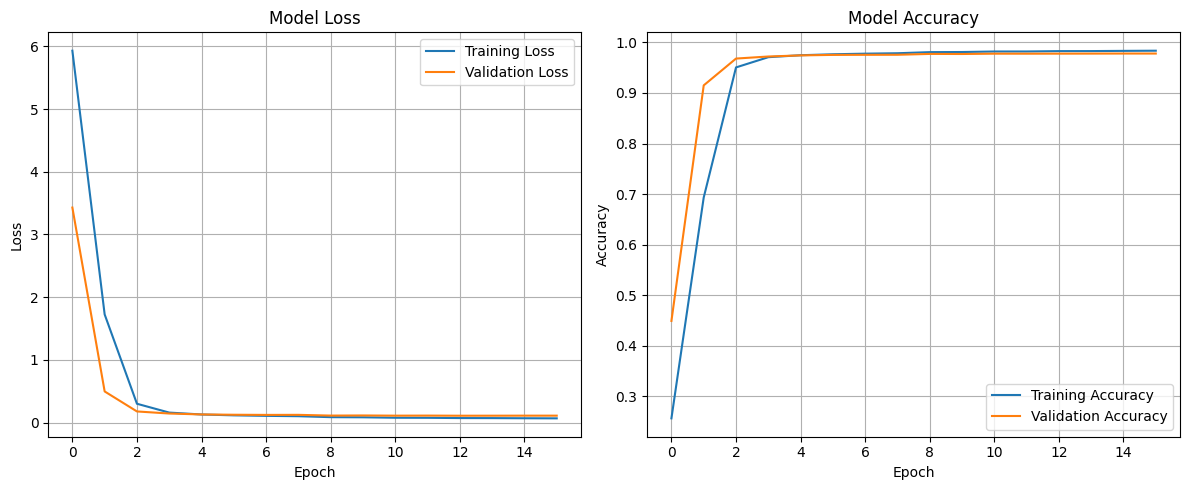

In [30]:
# Cell 7: Plot training metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Cell 8: Save the model
model.save('kalevala_model.keras')
print("Model saved as 'kalevala_model.keras'")

Model saved as 'kalevala_model.keras'


In [37]:
def generate_text(model, sp, prompt, num_tokens=100, temperature=1.0):
    """Generate text based on a prompt with proper lowercase handling."""
    # Convert prompt to lowercase to match training data
    lowercase_prompt = prompt#.lower()

    # Encode the prompt
    input_ids = sp.encode_as_ids(lowercase_prompt)

    # Rest of your generation code stays the same...
    if len(input_ids) < seq_length:
        padding_length = seq_length - len(input_ids)
        input_ids = [0] * padding_length + input_ids
    else:
        padding_length = 0
        input_ids = input_ids[-seq_length:]

    # Generated tokens
    generated_ids = list(input_ids[padding_length:])

    # Generate text token by token
    for _ in range(num_tokens):
        x = np.array([input_ids])
        predictions = model.predict(x, verbose=0)[0]
        logits = predictions[-1]
        logits = logits / temperature
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / np.sum(exp_logits)
        next_token = np.random.choice(len(probs), p=probs)
        generated_ids.append(next_token)
        input_ids = input_ids[1:] + [next_token]

    # Decode the generated sequence
    generated_text = sp.decode(generated_ids)

    return generated_text

In [38]:
# Cell 10: Generate sample text
prompts = [
    "Vaka vanha Väinämöinen",
    "Mieleni minun tekevi",
    "Lemminkäinen",
    "Pohjan neito"
]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    generated = generate_text(model, sp, prompt, num_tokens=100, temperature=1.2)
    print(generated)


Prompt: Vaka vanha Väinämöinen
Vaka vanha Väinämöinen, tietäjä iän-ikuinen; virkki nuori tulisen, väljiä vesiä! "Suvetar, valio vaimo, Etelätär, luonnon eukko! Käy nyt, syötä Syötikkini sekä juota Juotikkini, herustele Hermikkiä, tuorustele Tuorikkia, anna maito Mairikille, Omenalle uuet piimät hele'istä heinänpäistä, kaunihista kastikoista, mairehista maaemistä, metisistä mättähistä, nurmelta mesinukalta, maalta marjanvartiselta, kanervan-kukattarilta, heinän-helpehettäriltä, pilven piimätyttäriltä, taivahan-navattarilta, tuoa maitoiset maruet, aina uhkuvat utaret lypseä lyhyen vaimon, pienen piian piukutella! "Nouse,

Prompt: Mieleni minun tekevi
Mieleni minun tekevi juomahan soan olutta, soan mettä maistamahan." Tuon emo sanoiksi virkki: "Oi on Ahti poikaseni! Ellös lähtekö sotahan! On meillä oloista koissa leppäisessä lekkerissä tapin tammisen takana; tuon sinulle juoaksesi, josp' on joisit kaiken päivän." Sanoi lieto Lemminkäinen: "En huoli koto-oloista! Ennen juon joesta vettä m

In [ ]:
# Cell 11: Load model (if you're starting a new session)
# Uncomment these lines to load a previously saved model
"""
# Load saved model
model = keras.models.load_model('kalevala_model.keras')

# Load SentencePiece tokenizer
sp = spm.SentencePieceProcessor()
sp.load('kalevala_sp.model')

# Test generation
prompt = "Mieleni minun tekevi"
generated = generate_text(model, sp, prompt, num_tokens=150, temperature=1.0)
print(generated)
"""

'\n# Load saved model\nmodel = keras.models.load_model(\'kalevala_model.keras\')\n\n# Load SentencePiece tokenizer\nsp = spm.SentencePieceProcessor()\nsp.load(\'kalevala_sp.model\')\n\n# Test generation\nprompt = "Mieleni minun tekevi"\ngenerated = generate_text(model, sp, prompt, num_tokens=150, temperature=1.0)\nprint(generated)\n'